### Script that needs to:
- Chunk the data accordingly
- Baseline subtract (I guess?)
- Integrate over the peak (defined by the user I'd assume in our case)

Hardest part will be collecting the relevant information for each channel without the memory running out.

So it needs to collect all the waveforms from a channel while integrating and processing them. Can do this in the chunked manner.

In [1]:
import numpy as np
import sys
import math as m
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.stats as scs
from functools import partial
import pandas as pd
import h5py

sys.path.append("/home/e78368jw/Documents/MULE/")
import packs.core.io as iodf



In [ ]:
def subtract_baseline(y_data, type = 'median'):
    '''
    determines the value that should be subtracted to produce baseline
    '''


    # convert y_data to numpy array for your own sanity
    y_data = np.array(y_data)

    # MEAN METHOD
    # add all ADC values and divide by length (rough), also remove negatives
    if (type=='mean'):
        total = (np.sum(y_data)/len(y_data))
    # MODE METHOD
    elif (type=='mode'):
        value, counts = np.unique(y_data, return_counts=True)
        m = counts.argmax()
        # counteracting mode being stupid
        #if counts[m] == 1:
        #    print("Only one count of this value, please use a different method! (Mode sucks Brais >:( ))")
        #else:
        #    total = value[m]
        total = value[m]
        ## SCIPY IS SLOW!
        ##return (stats.mode(y_data))
    # MEDIAN METHOD
    elif (type=='median'):
        total = np.median(y_data)
    else:
        #print("Please input a baseline method, exiting...")
        return 0

    # return value to subtract
    return total


def integrate(y_data):
    '''
    collect the integral across an event by summing y components
    '''
    ####print("Baseline subtracted value: {}".format(y_data[25]))
    int_tot = np.sum(y_data)
    return(int_tot)


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or m.fabs(value - array[idx-1]) < m.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def collect_index(time, value):
    '''
    Collects the array index corresponding to a certain time value

    Args:
        time        (np.array)        :     Time array
        value       (float/int)       :     Value that you wish to locate the index of
    '''
    
    val = find_nearest(time, value)
    index = np.where(time == val)[0]

    if len(index == 1):
        return index[0]
    else:
        raise Exception("Must only collect one index! Are you sure you entered the right array?")


### the meaty function

def cook_data(data, bin_size, window_args, negative = False, baseline_mode = 'median', verbose = 0):
    '''
    Collects the charge histograms from waveform arrays via simple processing
    Spits out tuple containing BL-subtracted waveforms and charge of each signal.

    Args:
        data          (np.array)      :       Waveform data
        bin_size      (float)         :       Size of time bins within data
        window_args   (list)          :       list of window values for use in processing, ordered as such:
                                                     WINDOW_START    
                                                     WINDOW_END      
                                                     BASELINE_POINT_1
                                                     BASELINE_POINT_2
                                                     BASELINE_RANGE_1
                                                     BASELINE_RANGE_2
        negative      (bool)          :       Is the waveform negative? (flips to positive format)
        baseline_mode (string)        :       Mode of the baseline subtraction (median, mode, mean, etc).
        verbose       (int)          :       Print info: 0 is nothing, 1 is barebones, 2 includes plots

    Returns:
        results(
           sub_data   (array)         :       Baseline subtracted waveforms
           Q_data     (array)         :       Charge histogram data per waveform
        )


    '''
    # unpack window arguments
    ### TODO, PACK THIS IN AN ITERATIVE METHOD, THIS IS SILLY
    WINDOW_START     = window_args[0]   
    WINDOW_END       = window_args[1]
    BASELINE_POINT_1 = window_args[2]
    BASELINE_POINT_2 = window_args[3]
    BASELINE_RANGE_1 = window_args[4]  
    BASELINE_RANGE_2 = window_args[5]  


    # define time-span
    time = np.linspace(0,len(data[0]), num = len(data[0]), dtype = int) * bin_size


    start_index = collect_index(time, WINDOW_START)
    end_index   = collect_index(time, WINDOW_END)

    # make sure ranges dont go ape
    try:
        min_1 = BASELINE_POINT_1 - BASELINE_RANGE_1
        max_1 = BASELINE_POINT_1 + BASELINE_RANGE_1
        min_2 = BASELINE_POINT_2 - BASELINE_RANGE_2
        max_2 = BASELINE_POINT_2 + BASELINE_RANGE_2
        bl_range_1 = [collect_index(time, min_1),collect_index(time, max_1)]
        bl_range_2 = [collect_index(time, min_2),collect_index(time, max_2)]
    except:
        print(f'Range values out of range (lol): {min_1} - {max_1}, {min_2} - {max_2}')

    
    


    if (verbose > 0):
        print(f'{len(data)} events')
        print(f"Collecing sidebands across time ranges {min_1} - {max_1}, {min_2} - {max_2}")
        print(f"Sideband indexes: {bl_range_1[0]} - {bl_range_1[1]}, {bl_range_2[0]} - {bl_range_2[1]}")
        
        

    # currently doing this the lazy way (iteratively), will do it via mapping soon

    sub_data = []
    Q_data   = []
    i = 0 # annoying counter
    for wf in data:  # select each event to process

        # negative flip
        if (negative == True):
            wf = -wf

        #plot
        if (verbose > 1):

            plt.plot(time, wf)
            plt.axvspan(WINDOW_START, WINDOW_END, alpha = 0.3, color = 'red', label = 'Signal window')
            plt.axvspan(BASELINE_POINT_1 - BASELINE_RANGE_1, BASELINE_POINT_1 + BASELINE_RANGE_1, alpha = 0.3, color = 'blue', label = 'Baseline bands')
            plt.axvspan(BASELINE_POINT_2 - BASELINE_RANGE_2, BASELINE_POINT_2 + BASELINE_RANGE_2, alpha = 0.3, color = 'blue')
            plt.xlabel('Time (us)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} waveform')
            plt.legend()
            plt.show()
        
        ### baseline subtraction ###

        # take y values within sidebands, double index is because my formatting is stupid
        y_sideband = wf[bl_range_1[0]:bl_range_1[1]]
        y_sideband = list(y_sideband) + list(wf[bl_range_2[0]:bl_range_2[1]])

        # produce sub_wf
        sub_wf = wf - subtract_baseline(y_sideband, type = baseline_mode)
        sub_data.append(sub_wf)

        # calculate adc
        adc_val = integrate(sub_wf[start_index:end_index])
        Q_data.append(adc_val)

        if (verbose > 1):
            plt.plot(time, sub_wf)
            plt.xlabel('Time (us)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} subtracted waveform')
            plt.show()
        



        if (verbose > 0):
            print(f'Event {i} ADC value: {adc_val}')



        i += 1

    return (sub_data, Q_data)

def finger_signal(xs, bl, amp, gain, sigmabl, sigmaq, poismu, a0, a1, a2, maxpercent=0.99999):

    # Collect the position and amplitudes of the finger plot peaks
    poispeaks_pos = np.arange(0, scs.poisson.ppf(maxpercent, poismu))
    realpeaks_pos = gain * poispeaks_pos + bl
    realpeaks_amp = amp * scs.poisson.pmf(poispeaks_pos, poismu)

    # start y values collection
    result        = np.zeros_like(xs)

    # generate y values (results) that describe the poissonian distribution with
    # gaussian convolution across each peak
    for i in range(0, len(poispeaks_pos)):
            result += realpeaks_amp[i] * scs.norm.pdf(xs, loc=realpeaks_pos[i],
                                                    scale=np.sqrt(sigmabl**2 + sigmaq**2 * i))
    return result + a0 + a1*xs + a2*xs**2
'''
# stealing brais' function hehe sorry brais
def finger_signal( xs, bl, A, gain, sigmaq, poismu, maxpercent=0.99999): # Define the fit function
    
    poispeaks_pos = np.arange(0, scs.poisson.ppf(maxpercent, 1)) # Poisson peak position
    realpeaks_pos = gain * poispeaks_pos + bl # Positions of n_pe peaks
    realpeaks_amp = A * scs.poisson.pmf(poispeaks_pos, poismu) # Amplitude of n_pe peaks 
    result        = np.zeros_like(xs) # Create an array of zeros of the same shape as the data given to the fit.
    
    for i in range(len(poispeaks_pos)):
        result += realpeaks_amp[i] * scs.norm.pdf(xs, loc=realpeaks_pos[i], scale=sigmaq*np.sqrt(i+1))

    return result
'''

"\n# stealing brais' function hehe sorry brais\ndef finger_signal( xs, bl, A, gain, sigmaq, poismu, maxpercent=0.99999): # Define the fit function\n    \n    poispeaks_pos = np.arange(0, scs.poisson.ppf(maxpercent, 1)) # Poisson peak position\n    realpeaks_pos = gain * poispeaks_pos + bl # Positions of n_pe peaks\n    realpeaks_amp = A * scs.poisson.pmf(poispeaks_pos, poismu) # Amplitude of n_pe peaks \n    result        = np.zeros_like(xs) # Create an array of zeros of the same shape as the data given to the fit.\n    \n    for i in range(len(poispeaks_pos)):\n        result += realpeaks_amp[i] * scs.norm.pdf(xs, loc=realpeaks_pos[i], scale=sigmaq*np.sqrt(i+1))\n\n    return result\n"

In [3]:
print(np.polynomial.Polynomial([1, 1, 2, 3]))

1.0 + 1.0·x + 2.0·x² + 3.0·x³


In [4]:
#def save_data(swf                :  np.ndarray, 
#              save_path          :  str, 
#              event_number       :  Optional[int] = 0):
#    '''
#    Produces the h5 files given the event information and raw waveforms
#
#    Parameters
#    ----------
#
#        event_information  (ndarray)  :  Event information from the binary file
#        rwf                (ndarray)  :  Raw waveforms from the binary file
#        save_path          (str)      :  Path to saved file
#        event_number       (int)      :  The first event number in the file (generally)
#
#    Returns
#    -------
#
#        None
#
#    '''
#    try:
#        # check if first set of events, if so 'w', otherwise 'a'
#        if event_number == 0:
#            h5f = h5py.File(save_path, 'w')
#            rwf_grp = h5f.create_group('swf')
#        else:
#            h5f = h5py.File(save_path, 'a')
#            rwf_grp = h5f.require_group('swf')
#
#        # write waveforms
#        rwf_grp.create_dataset('swf_' + str(event_number), data=rwf)
#
#        h5f.close()
#    finally:
#        # close if it exists. This is a silly catch case
#        # only included to ensure if some weirdness happens the file will close
#        if isinstance(h5f, io.IOBase):
#            h5f.close()


In [5]:
#with h5py.File('test_dir/58V_50mu.h5') as f:
#    rwf_info = f.get('rwf')
#    for i in rwf_info.keys():
#        print(i)
#        q = rwf_info.get(str(i))
#        print(q)
#        for j in q:
#            # take first event number for counter
#            counter = j[0]
#            plt.plot(np.linspace(0, len(j[2]), len(j[2]))*8, j[2]) # 8 ns is sampling period I believe
#            plt.xlabel('ns')
#            plt.ylabel('ADCs')
#            plt.show()
#            # subtract baseline via median
#            # leave this for later, we just want to integrate
#            break

### Load in data here

if the files big, you will struggle.
**MAKE SURE THE SAMPLE RATE IS CORRECT**
set here to 16000

In [6]:
with h5py.File('test_dir/58V_50mu.h5') as f:
    rwf_info = f.get('rwf')
    for i in rwf_info.keys():
        q = rwf_info.get(str(i))
        samples = q.shape[0]
        print(f'number of samples: {samples}')

number of samples: 16000
number of samples: 16000
number of samples: 16000
number of samples: 16000
number of samples: 16000


In [7]:
evt_data = iodf.load_evt_info('test_dir/58V_50mu.h5')
display(evt_data)

,event_number,timestamp,samples,sampling_period,channels
0,0,24307,3752,8,16
1,1,149306,3752,8,16
2,2,274306,3752,8,16
3,3,399306,3752,8,16
4,4,524306,3752,8,16
...,...,...,...,...,...
4995,14061,1757646003,3752,8,16
4996,14062,1757771003,3752,8,16
4997,14063,1757896002,3752,8,16
4998,14064,1758021002,3752,8,16


In [8]:
rwf_data = iodf.load_rwf_info('test_dir/58V_50mu.h5', 3752)

In [9]:
#display(rwf_data)
#for j in rwf_data.groupby(['channels']):
    #print(f'i: {i}')
#    print(f'channel: {j[0][0]}')
#    display(j[1].rwf)


In [10]:
#display(rwf_data)
#display(rwf_data[rwf_data.event_number == 0])
#print(rwf_data[rwf_data.event_number == 0].rwf)

# this only exists for plotting below
func_data = rwf_data[rwf_data.event_number == 0].rwf

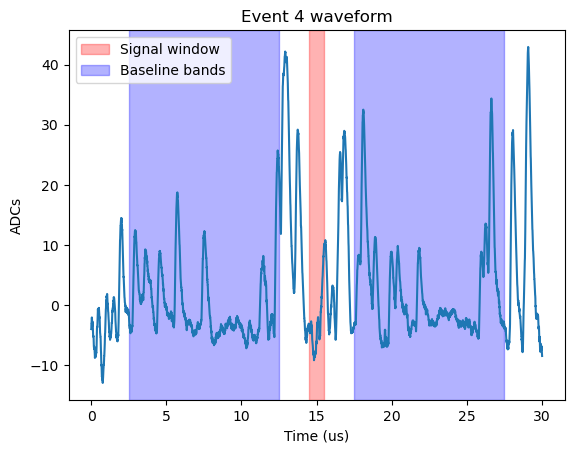

In [11]:
# MISC VALUES
bin_size         = 0.008           # us, time spacing between bins
var              = 4               # waveforn number for visualising
negative         = False            # flips from negative to positive

# WINDOW VALUES
WINDOW_START     = 14.5              # us
WINDOW_END       = 15.5              # us
BASELINE_POINT_1 = 7.5               # us, DONT SET THIS TO THE MINIMUM (0)
BASELINE_POINT_2 = 22.5              # us, DONT SET THIS TO THE MAXIMUM
BASELINE_RANGE_1  = 5              # us, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM
BASELINE_RANGE_2  = 5             # us, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM

# PACKAGING THE WINDOW VALUES
window_args = [WINDOW_START, WINDOW_END, BASELINE_POINT_1, BASELINE_POINT_2, BASELINE_RANGE_1, BASELINE_RANGE_2]



time = np.linspace(0,len(func_data[var]), num = len(func_data[var]), dtype = int)
time = time * bin_size # reshape

if (negative == True):
    plt.plot(time, -func_data[var])
elif (negative == False):
    plt.plot(time, func_data[var])
plt.axvspan(WINDOW_START, WINDOW_END, alpha = 0.3, color = 'red', label = 'Signal window')
plt.axvspan(BASELINE_POINT_1 - BASELINE_RANGE_1, BASELINE_POINT_1 + BASELINE_RANGE_1, alpha = 0.3, color = 'blue', label = 'Baseline bands')
plt.axvspan(BASELINE_POINT_2 - BASELINE_RANGE_2, BASELINE_POINT_2 + BASELINE_RANGE_2, alpha = 0.3, color = 'blue')
plt.xlabel('Time (us)')
plt.ylabel('ADCs')
plt.title(f'Event {var} waveform')
plt.legend()
plt.show()

# This is where the results are generated, make sure you have the folder `calibration_images` ready to take the plots

In [12]:
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0

channel: (0,)
        Fitting output      
bl: -845.3807 ± 7.4183
amp: 327373.7279 ± 5687.2070
gain: 704.0647 ± 8.2747
sigmabl: 205.2161 ± 6.2144
sigmaq: 100.0000 ± 16.7009
poismu: 0.9467 ± 0.0225
a0: 4.6638 ± 0.8252
a1: -0.0003 ± 0.0004
a2: -0.0000 ± 0.0000


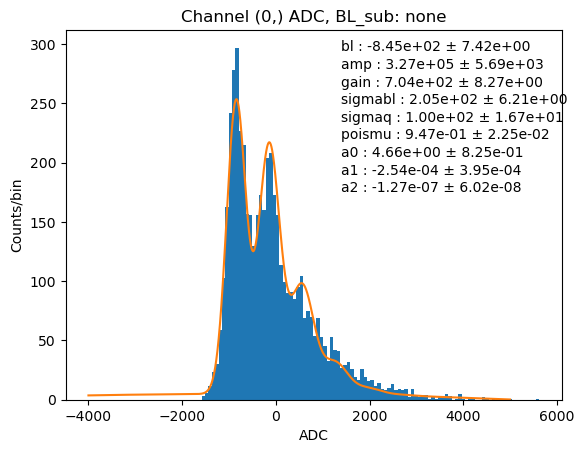

channel: (1,)
        Fitting output      
bl: -927.2828 ± 6.1081
amp: 301524.0020 ± 5691.4112
gain: 623.8278 ± 6.4455
sigmabl: 164.2876 ± 5.2899
sigmaq: 100.0000 ± 10.4035
poismu: 1.1447 ± 0.0223
a0: 3.3968 ± 1.0638
a1: 0.0003 ± 0.0006
a2: -0.0000 ± 0.0000


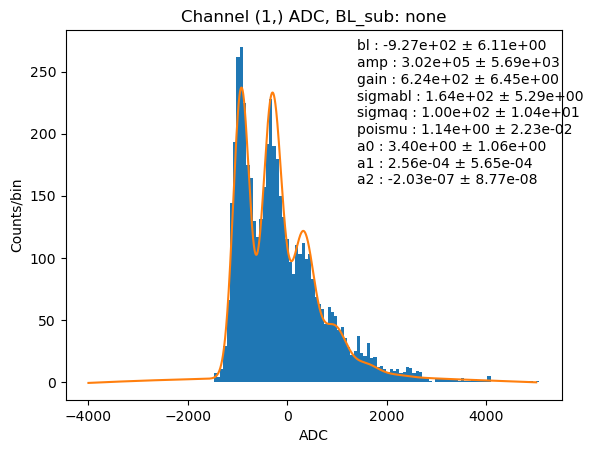

channel: (2,)
        Fitting output      
bl: -1209.2160 ± 5.2726
amp: 394652.0785 ± 6243.3884
gain: 662.4423 ± 5.8143
sigmabl: 166.6855 ± 4.3578
sigmaq: 100.0000 ± 9.5697
poismu: 1.0293 ± 0.0191
a0: 2.0770 ± 0.6055
a1: 0.0003 ± 0.0003
a2: -0.0000 ± 0.0000


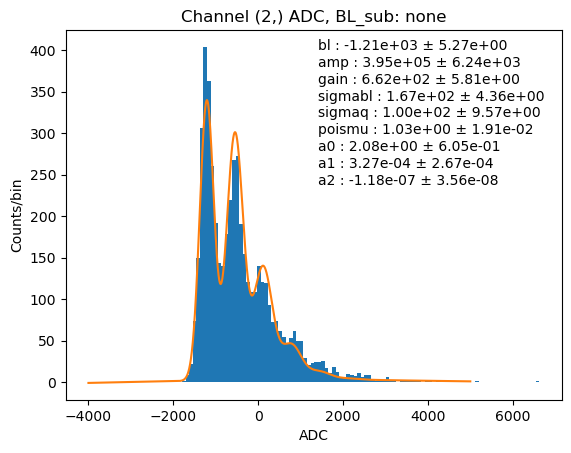

channel: (3,)
        Fitting output      
bl: -1139.3277 ± 43.1003
amp: 526238.6267 ± 25893.8147
gain: 1229.2008 ± 53.2221
sigmabl: 521.5062 ± 29.1161
sigmaq: 100.0000 ± 166.7055
poismu: 0.7668 ± 0.0619
a0: 0.4446 ± 4.5012
a1: 0.0005 ± 0.0013
a2: -0.0000 ± 0.0000


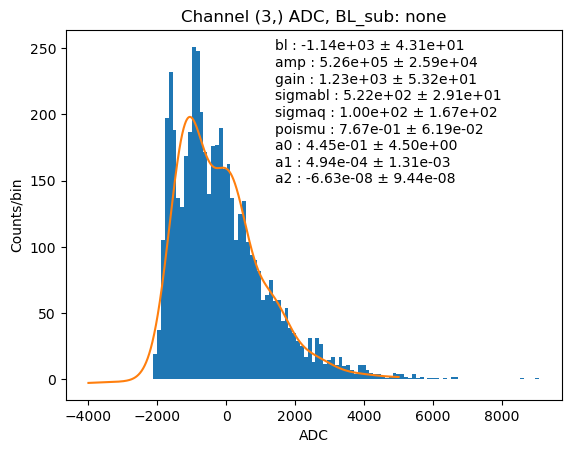

channel: (4,)
        Fitting output      
bl: -1174.7611 ± 8.3937
amp: 582204.0270 ± 14215.2531
gain: 669.4844 ± 6.5649
sigmabl: 209.7436 ± 7.8119
sigmaq: 92.7441 ± 10.7073
poismu: 2.0221 ± 0.0246
a0: -81.7945 ± 3.8898
a1: 0.0374 ± 0.0019
a2: -0.0000 ± 0.0000


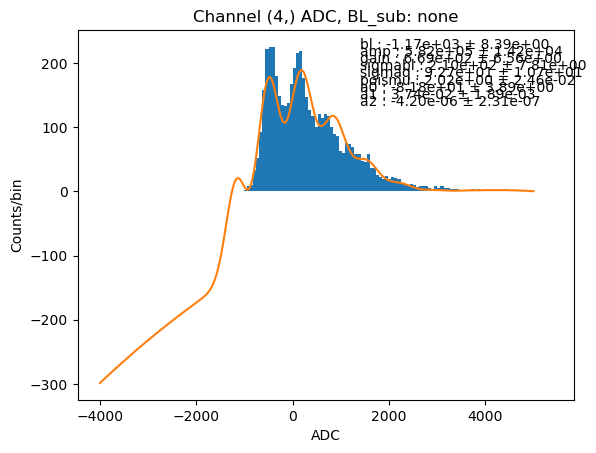

channel: (5,)
        Fitting output      
bl: -1273.5246 ± 13.2321
amp: 840306.2188 ± 24207.8334
gain: 866.8057 ± 8.9741
sigmabl: 306.3955 ± 11.0010
sigmaq: 99.9990 ± 17.1781
poismu: 1.6763 ± 0.0187
a0: -132.3803 ± 6.0476
a1: 0.0522 ± 0.0025
a2: -0.0000 ± 0.0000


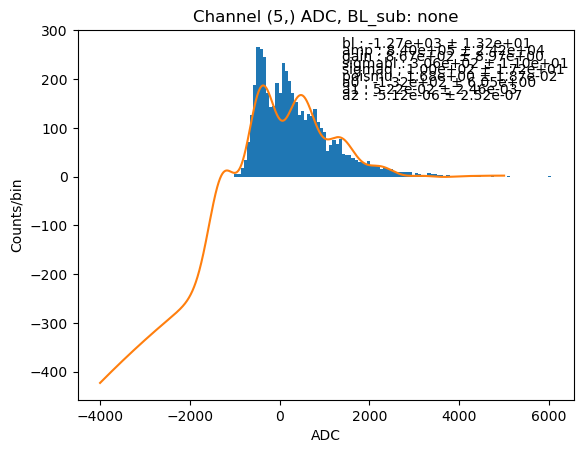

channel: (6,)
        Fitting output      
bl: -946.5916 ± 6.4580
amp: 320766.6806 ± 5101.6978
gain: 630.7835 ± 6.4581
sigmabl: 171.1618 ± 5.2123
sigmaq: 100.0000 ± 11.1432
poismu: 1.1950 ± 0.0234
a0: 2.5061 ± 0.5094
a1: 0.0007 ± 0.0002
a2: -0.0000 ± 0.0000


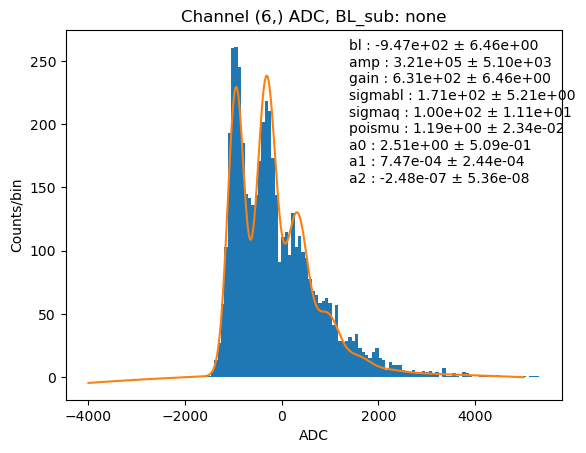

channel: (7,)
        Fitting output      
bl: -998.3515 ± 7.0490
amp: 341107.7544 ± 7153.5303
gain: 638.6781 ± 7.0648
sigmabl: 170.3127 ± 6.1993
sigmaq: 100.0000 ± 11.5824
poismu: 1.2256 ± 0.0244
a0: 8.5576 ± 1.4134
a1: -0.0020 ± 0.0006
a2: 0.0000 ± 0.0000


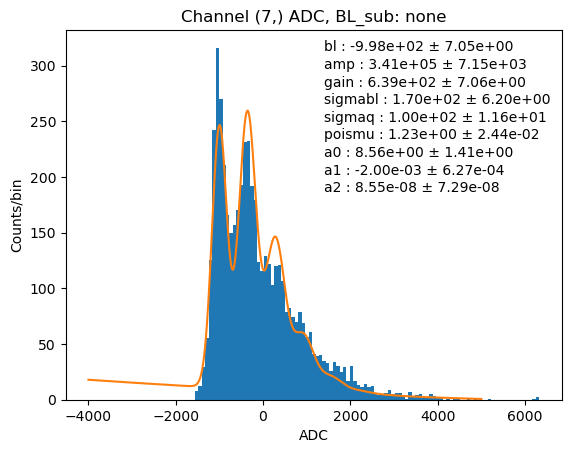

channel: (8,)
        Fitting output      
bl: -860.0335 ± 6.8189
amp: 282620.3491 ± 5905.1074
gain: 609.7286 ± 7.4200
sigmabl: 169.8701 ± 6.1970
sigmaq: 100.0000 ± 12.2233
poismu: 1.1584 ± 0.0247
a0: 4.3122 ± 1.3185
a1: -0.0000 ± 0.0007
a2: -0.0000 ± 0.0000


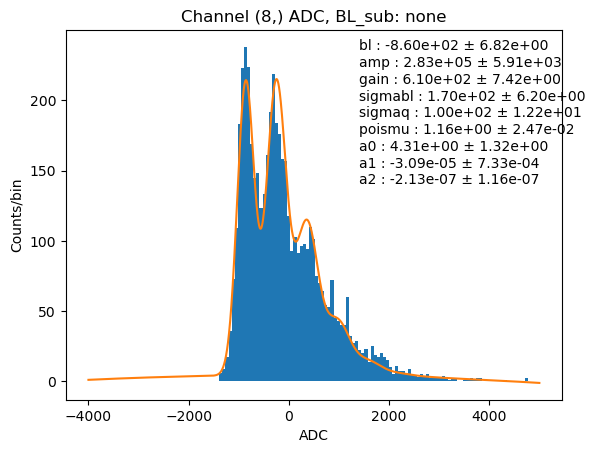

channel: (9,)
        Fitting output      
bl: -969.7591 ± 6.9492
amp: 394898.2132 ± 7307.6225
gain: 702.2114 ± 6.8237
sigmabl: 188.4614 ± 6.0280
sigmaq: 99.9066 ± 12.0850
poismu: 1.1807 ± 0.0220
a0: 4.2459 ± 1.2085
a1: -0.0005 ± 0.0005
a2: -0.0000 ± 0.0000


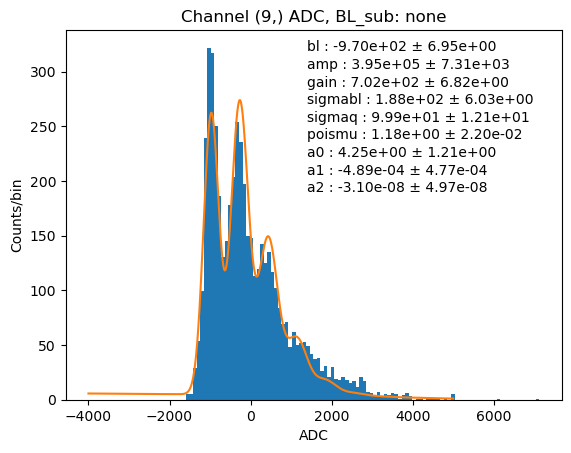

channel: (10,)
        Fitting output      
bl: -18198.4190 ± 0.0000
amp: 78.5903 ± 0.0000
gain: 3888.4434 ± 0.0000
sigmabl: 9676.0929 ± 0.0000
sigmaq: 0.0952 ± 0.0000
poismu: 2.9962 ± 0.0003
a0: 25.5501 ± 0.8247
a1: -0.0062 ± 0.0003
a2: 0.0000 ± 0.0000


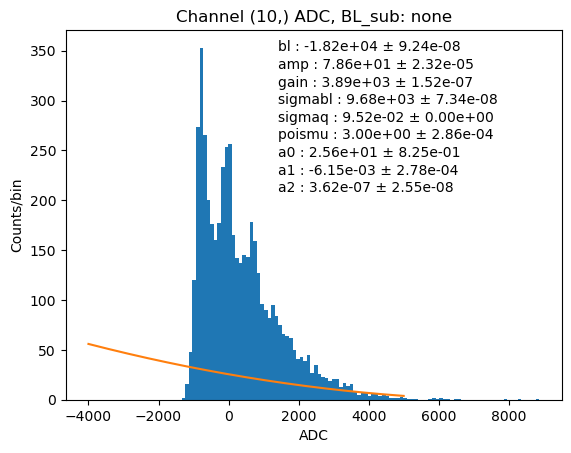

channel: (11,)
        Fitting output      
bl: -695.4873 ± 5.5562
amp: 332465.6451 ± 5353.0549
gain: 649.6388 ± 6.1455
sigmabl: 167.8143 ± 4.5045
sigmaq: 100.0000 ± 10.0160
poismu: 1.0411 ± 0.0201
a0: 1.9260 ± 0.6653
a1: 0.0009 ± 0.0003
a2: -0.0000 ± 0.0000


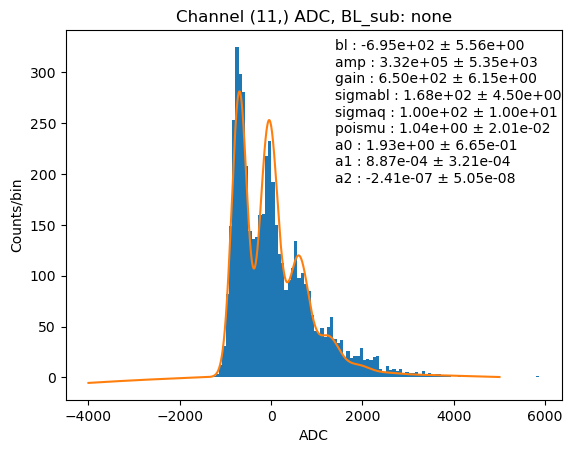

channel: (12,)
        Fitting output      
bl: -621.1223 ± 5.6270
amp: 378700.8270 ± 6247.7185
gain: 651.4795 ± 6.3901
sigmabl: 170.3053 ± 4.6919
sigmaq: 100.0000 ± 10.7671
poismu: 1.0240 ± 0.0202
a0: 4.0754 ± 0.8623
a1: -0.0001 ± 0.0004
a2: -0.0000 ± 0.0000


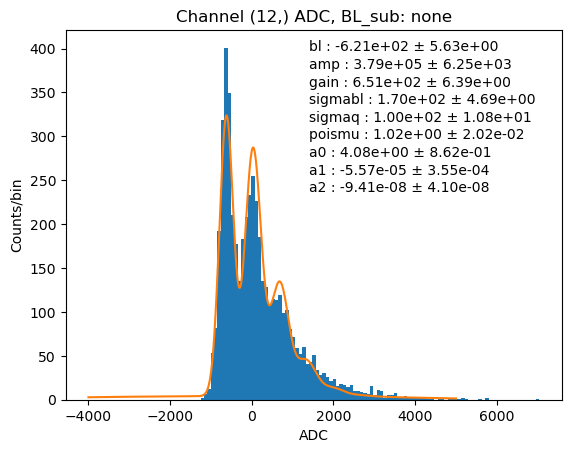

channel: (13,)
        Fitting output      
bl: -672.1849 ± 6.1884
amp: 304712.7254 ± 4952.6312
gain: 599.9077 ± 7.1558
sigmabl: 169.9415 ± 4.9418
sigmaq: 100.0000 ± 12.5383
poismu: 0.9921 ± 0.0224
a0: 2.4250 ± 0.7029
a1: -0.0000 ± 0.0004
a2: -0.0000 ± 0.0000


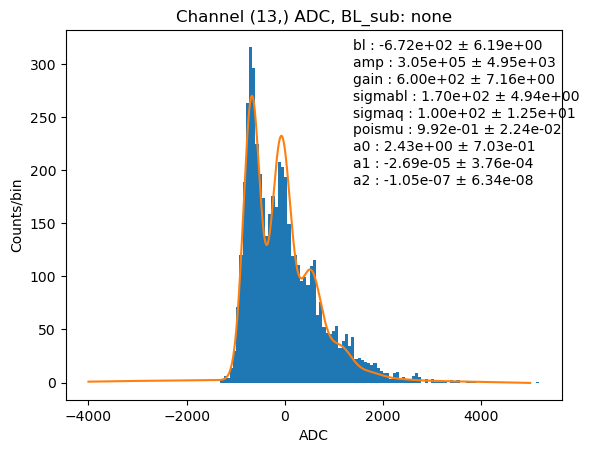

channel: (14,)
        Fitting output      
bl: -899.3597 ± 7.9598
amp: 400953.1019 ± 8265.6632
gain: 690.3387 ± 7.2325
sigmabl: 193.4751 ± 6.9824
sigmaq: 99.9246 ± 12.3856
poismu: 1.3246 ± 0.0232
a0: -0.8989 ± 1.7148
a1: 0.0016 ± 0.0007
a2: -0.0000 ± 0.0000


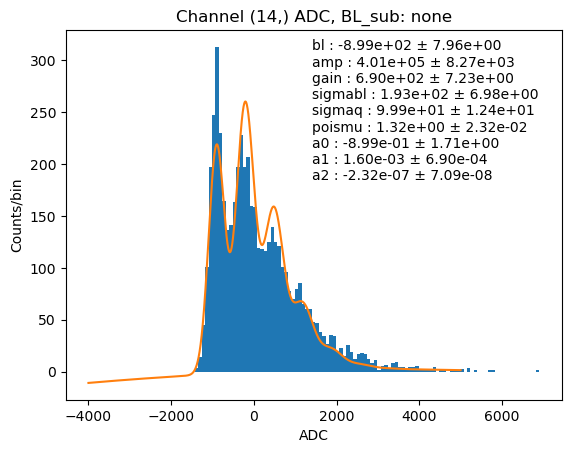

channel: (15,)
        Fitting output      
bl: -776.0528 ± 6.0194
amp: 354504.6061 ± 7322.0272
gain: 665.1230 ± 6.9186
sigmabl: 172.7037 ± 5.1658
sigmaq: 100.0000 ± 11.4694
poismu: 0.9838 ± 0.0207
a0: 9.8696 ± 1.5746
a1: -0.0028 ± 0.0007
a2: 0.0000 ± 0.0000


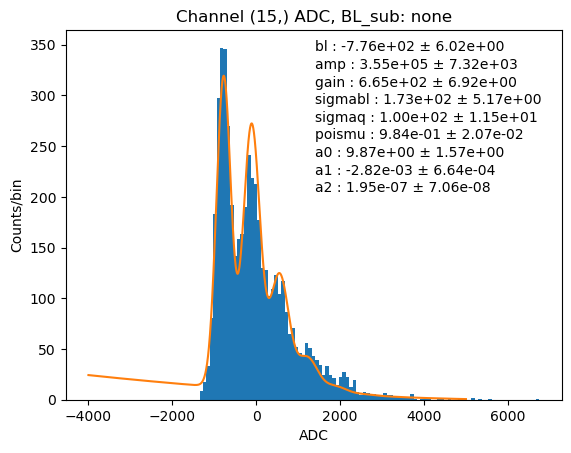

In [30]:

xaux = np.linspace(-4000, 5000, 10000)

results_array = []

#seeds = [4.089e6, 9e6, 6000, 446, 0.7]
#bounds = ((1e5, 0, 1e3, 1e2, 0.1),(5e6, np.inf, 1e5, 1e6, 5))

func = partial(finger_signal, maxpercent=0.9999999999)#, K=10, mscale=2.2)
#funcd = lambda xs, bl, amp, gain, sigmabl, sigmaq, poismu, a0, a1, a2, a3: func(xs, bl, amp, gain, sigmabl, sigmaq, poismu) + np.polynomial([a0, a1, a2, a3])


labels = ['bl', 'amp', 'gain', 'sigmabl', 'sigmaq', 'poismu', 'a0', 'a1', 'a2']
for j in rwf_data.groupby(['channels']):
    #print(f'i: {i}')
    print(f'channel: {j[0]}')
    #display(j[1])
    #print(j[1].rwf)
    baseline_mode = 'none'
    # cook
    a = cook_data(j[1].rwf.reset_index(drop=True), bin_size, window_args, negative = negative, baseline_mode = baseline_mode, verbose = 0)

    # fit
    #seeds = [-1000, 500000, 800, 100, 1, 1]
    seeds = [-1000, 500000, 800, 100, 1, 1, 0, 0, 0]
    #bounds = [[-np.inf, -np.inf, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, 100, np.inf]]
    bounds = [[-np.inf, -np.inf, -np.inf, 0.0, 0.0, 0.0, -1000, -1000, -1000], [np.inf, np.inf, np.inf, np.inf, 100, np.inf, 1000, 1000, 1000]]
    heights, bin_edges, _ = plt.hist(a[1], bins = 100)
    bins = (bin_edges[:-1] + bin_edges[1:]) / 2

    # plotting shit
    percentage_hor = 0.6
    percentage_vert = 0.99
    x_loc = np.min(xaux) + (np.max(xaux) - np.min(xaux))*percentage_hor
    y_loc = np.min(heights) + (np.max(heights) - np.min(heights))*percentage_vert
    # reasonable gap for separation, based on scale
    gap = (np.max(heights) - np.min(heights)) * 0.05

    # fitting shit
    uncertainty = np.sqrt(heights)
    uncertainty[uncertainty == 0] = 1
    fit_res = sco.curve_fit(func, bins, heights, p0 = seeds, bounds = bounds, maxfev = 500000, sigma = uncertainty, absolute_sigma=True)#, bounds = bounds)#, maxfev = 5000000, p0 = seeds, bounds = bounds)
    print_parameters(fit_res[0], fit_res[1], labels)
    
    #plt.plot(bins, heights)
    plt.plot(xaux, func(xaux, *fit_res[0]), label = 'fit')

    for i in range(len(fit_res[0])):
            plt.text(x_loc, y_loc - gap*i, f'{labels[i]} : {fit_res[0][i]:.2e} ± {np.sqrt(fit_res[1][i][i]):.2e}')
            #plt.text(x_loc, y_loc - gap*i, str(labels[i]) + ": " + str(round(fit_res[0][i], 2)), verticalalignment='top', horizontalalignment='left')
    
    plt.title(f'Channel {j[0]} ADC, BL_sub: {baseline_mode}')
    plt.xlabel('ADC')
    plt.ylabel('Counts/bin')
    plt.savefig(f'calibration_images/ADChist_{j[0]}.png')
    plt.show()
    results_array.append(a)
    #if j[0][0] > 3:
    #    break


In [35]:
save_array = []
for i in range(len(results_array)):
    save_array.append(results_array[i][1])

x = np.array(save_array)

print(x)

np.save('ADC_data.npy', x)

[[   61.376     1007.4241      67.52     ...   -83.39198   -306.496
   1814.0801  ]
 [ -608.768      305.60004   -900.032    ...  -828.8641    -368.00003
     67.455986]
 [-1107.9679    -579.26404   -904.8319   ...  -266.11197   -808.448
  -1130.88    ]
 ...
 [ -941.568     -610.3039    -590.20795  ...  1604.864     -324.16
    237.248   ]
 [ 3024.3198    -616.832     2773.888    ...   758.848     3875.4558
   -352.768   ]
 [-1103.6969    -781.76715   -775.59296  ... -1284.381     1889.4329
    101.618996]]


### quickly save the ADC data for Tong

In [ ]:
#save_path = 'test_dir/58V_50mu.h5'

#with h5py.File(save_path, 'w') as h5f:
#    q_data = h5f.create_group('charge_data')
#    q_data.create_dataset('')

[-1.17476108e+03  5.82204027e+05  6.69484385e+02  2.09743615e+02
  9.27441143e+01  2.02206916e+00 -8.17945113e+01  3.73521924e-02
 -4.19562328e-06]


(-100.0, 100.0)

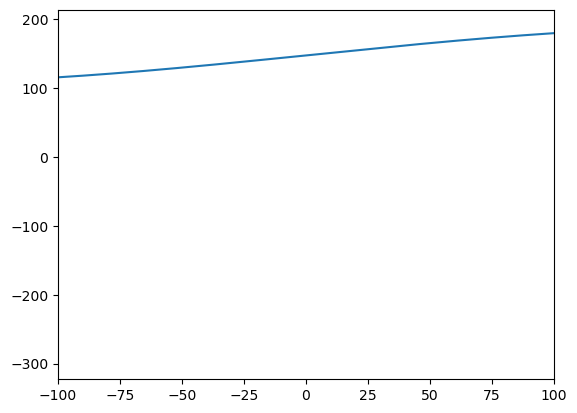

In [14]:
print(fit_res[0])
plt.plot(xaux, func(xaux, *fit_res[0]), label = 'fit')
plt.xlim([-100, 100])

TypeError: finger_signal() missing 3 required positional arguments: 'a0', 'a1', and 'a2'

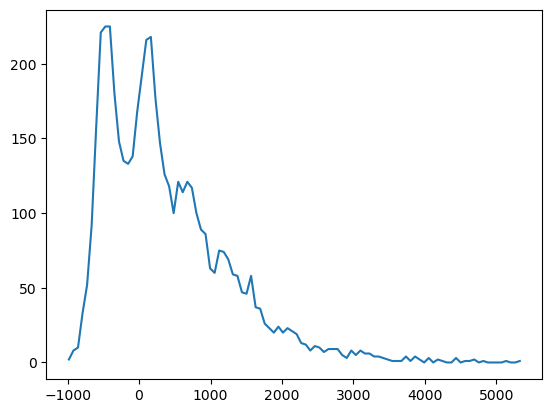

In [15]:
plt.plot(bins, heights)
plt.plot(xaux, func(xaux, -1000, 500000, 300, 150, 150, 1), label = 'fit')

In [16]:
#print(results_array[0][1])
#plt.hist(results_array[0][1], bins = 100)